In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
%run -i '../../../../../utils.py'

# Get data

In [ ]:
# read meta data
df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_meta = df_meta.drop('Diet', axis=1)
df_meta.head()

In [ ]:
# read SCFA data
df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)
df_scfa.head()

In [ ]:
# read bacterial abundance
df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)
df_bac.head()

# Run ElasticNet

In [5]:
for feedback in [True, False]:
    df_elasnet, _ = train_scfa_dynamics_model(
        df_meta = df_meta, 
        df_bac = df_bac, 
        df_scfa = df_scfa, 
        target_scfa=['Acetate','Butyrate','Propionate'],
        topN=40,
        normalize_X=True,
        exclude_group=None,
        exclude_vendor=None,
        model='ElasticNet',
        feedback=feedback)
    if feedback:
        df_elasnet.to_csv('elasnet_regression_w_feedback.csv')
    else:
        df_elasnet.to_csv('elasnet_regression_no_feedback.csv')

# Run RandomForest

In [8]:
for feedback in [True, False]:
    df_rf_reg, df_rf_opt_paras, _ = train_scfa_dynamics_model(
        df_meta = df_meta, 
        df_bac = df_bac, 
        df_scfa = df_scfa, 
        target_scfa=['Acetate','Butyrate','Propionate'],
        topN=40,
        normalize_X=True,
        exclude_group=None,
        exclude_vendor=None,
        model='RandomForest',
        feedback=feedback)
    if feedback:
        df_rf_opt_paras.to_csv('optimal_rf_parameters_w_feedback.csv')
        df_rf_reg.to_csv('rf_regression_w_feedback.csv')
    else:
        df_rf_opt_paras.to_csv('optimal_rf_parameters_no_feedback.csv')
        df_rf_reg.to_csv('rf_regression_no_feedback.csv')

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 40.3min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 38.7min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 36.2min finished


# Plot SCFA producer and consumer

In [6]:
def plot_scfa_producer_or_consumer(df_elasnet, df_rf, producer=True, topN=10, figsize=(10,6), save=False):
    # reformat elastic net
    df_elasnet = df_elasnet.stack().reset_index()
    df_elasnet = df_elasnet[~df_elasnet.level_1.isin(['BestAlpha','BestL1Ratio','R2'])]
    df_elasnet.columns=['SCFA','Variable','Coefficient']
    df_elasnet = df_elasnet.reset_index(drop=True)

    # reformat random forest
    df_rf = df_rf.stack().reset_index()
    df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
    df_rf.columns=['SCFA','Variable','Gini']
    df_rf = df_rf.reset_index(drop=True)

    # merge two tables
    df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
    df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']

    # remove features with ElasticNet=0
    if producer:
        df_joined = df_joined[df_joined.ElasticNet>0]
    else:
        df_joined = df_joined[df_joined.ElasticNet<0]
    all_scfa = sorted(set(df_joined.SCFA))
    
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=len(all_scfa), constrained_layout=True, sharex=True)
    cbar_ax = fig.add_axes([0.94, .45, .015, .2])
    for k,scfa in enumerate(all_scfa):
        curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
        curr_df = curr_df.drop('SCFA', axis=1)
        curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
        curr_df = curr_df.iloc[0:topN,:] 

        # normalize to -1 and 1
        for c in ['ElasticNet','RandomForest']:
            if producer==False and c=='ElasticNet':
                curr_df[c] = curr_df[c]/np.abs(curr_df[c].min())
            else:
                curr_df[c] = curr_df[c]/np.abs(curr_df[c].max())

        # plot    
        _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
        ax[k].set_xticklabels(['RandomForest','ElasticNet'], rotation=90, fontsize=12)
        ax[k].set_title(scfa, fontsize=15)
        ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
        ax[k].tick_params(axis=u'both', which=u'both',length=0)
        
    # save to figure
    if save:
        plt.rcParams['svg.fonttype'] = 'none'
        if producer:
            fig.savefig("scfa_producer_no_feedback_top%d.svg"%(topN), format="svg")
        else:
            fig.savefig("scfa_consumer_no_feedback_top%d.svg"%(topN), format="svg")
        
    plt.tight_layout()

## no feedback

In [7]:
df_elasnet = pd.read_csv('elasnet_regression_no_feedback.csv', index_col=0).set_index('SCFA')
df_rf = pd.read_csv('rf_regression_no_feedback.csv', index_col=0).set_index('SCFA')

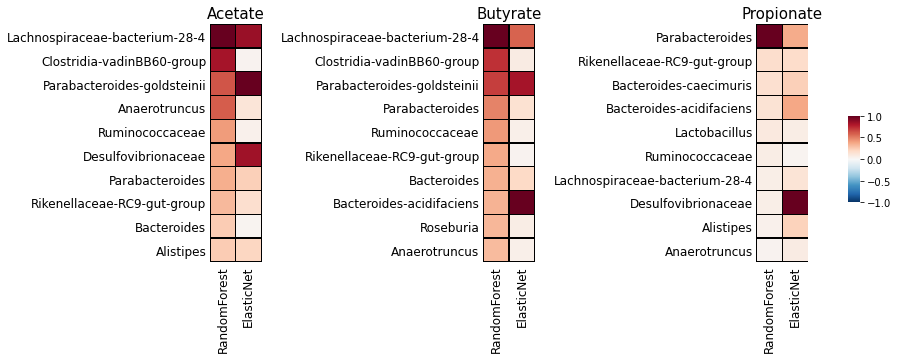

In [8]:
plot_scfa_producer_or_consumer(df_elasnet, df_rf, producer=True, figsize=(11,6), save=False)

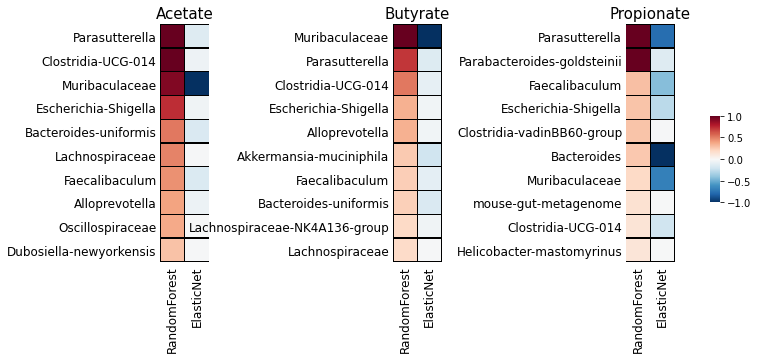

In [9]:
plot_scfa_producer_or_consumer(df_elasnet, df_rf, producer=False, figsize=(9.5,6), save=False)

## w/ feedback

In [23]:
df_elasnet = pd.read_csv('elasnet_regression_w_feedback.csv', index_col=0).set_index('SCFA')
df_rf = pd.read_csv('rf_regression_w_feedback.csv', index_col=0).set_index('SCFA')

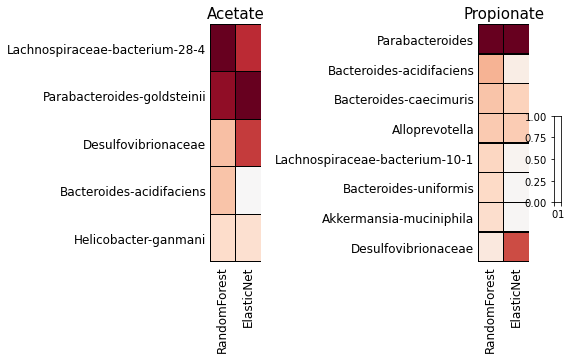

In [28]:
plot_scfa_producer_or_consumer(df_elasnet, df_rf, producer=True, figsize=(6,6), save=False)

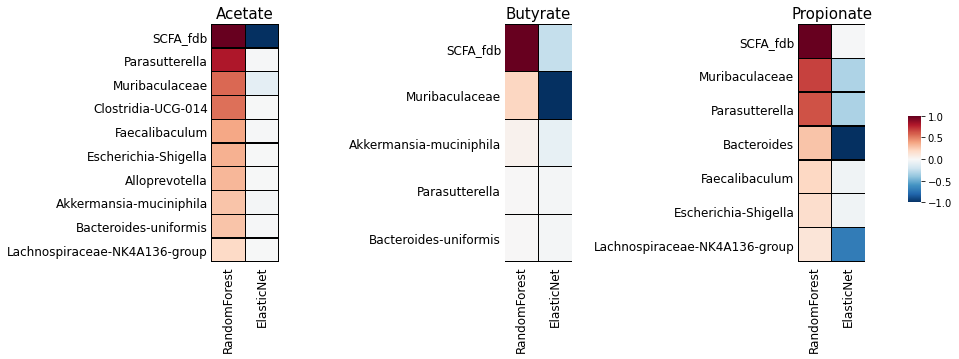

In [26]:
plot_scfa_producer_or_consumer(df_elasnet, df_rf, producer=False, figsize=(12,6), save=False)

# Compare observed and predicted SCFA derivatives 

In [29]:
def predict_scfa_deriv(feedback=False):
    df_pred = None

    # get raw data
    df_meta = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
    df_meta = df_meta[df_meta.Diet=='Inulin']
    df_meta = df_meta.drop('Diet', axis=1)
    df_scfa = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)
    df_bac = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)

    # get trained model
    target_scfa=['Acetate','Butyrate','Propionate']
    if feedback:
        df_opt_paras = pd.read_csv('optimal_rf_parameters_w_feedback.csv', index_col=0)
    else:
        df_opt_paras = pd.read_csv('optimal_rf_parameters_no_feedback.csv', index_col=0)

    target_scfa_sliced, df_meta_sliced, df_bac_sliced, df_scfa_sliced, df_scfa_deriv = data_processing_scfa(
        df_meta, df_bac, df_scfa, target_scfa, topN=40, normalize_X=True, exclude_group=None, exclude_vendor=None)

    _,_,reg = train_scfa_dynamics_model(
        df_meta=df_meta, # meta data
        df_bac=df_bac,  # relative abundace or absolute abundance of gut microbiome
        df_scfa=df_scfa, # SCFA measurement
        target_scfa=target_scfa, # dependent variable(s) in the regression
        topN=40, # keep only the most abundance N taxa in the model
        normalize_X=True, # normalize maximum of bacterial abundance to 1
        exclude_group=None, # group of mice excluded from model training
        exclude_vendor=None, # group of mice excluded from model training
        model='RandomForest',# regression model
        opt_params = df_opt_paras, # optimal model parameters
        feedback=feedback # if True, add SCFA feedback, i.e., dSCFA/dt = f(microbiome, SCFA)
    )

    # predict SCFA derivative
    for scfa_ in target_scfa:
        df_pred_tmp = deepcopy(df_scfa_deriv)
        df_pred_tmp = df_pred_tmp[[x for x in df_pred_tmp.columns if x not in list(set(target_scfa)-set([scfa_]))]]
        df_pred_tmp = df_pred_tmp.rename({scfa_:'SCFA_deriv_observed'}, axis=1)
        df_pred_tmp['SCFA_mol'] = scfa_
        df_pred_tmp['SCFA_value_observed'] = df_scfa_sliced[scfa_]

        if feedback:
            X_var = np.concatenate((np.asarray(df_bac_sliced.values), np.asarray(df_scfa_sliced[scfa_]).reshape(-1,1)), 1)
        else:
            X_var = np.asarray(df_bac_sliced.values)
        df_pred_tmp['SCFA_deriv_predicted'] = reg[scfa_].predict(X_var)

        if df_pred is None:
            df_pred = df_pred_tmp
        else:
            df_pred = pd.concat([df_pred, df_pred_tmp], ignore_index=True)

    return df_pred

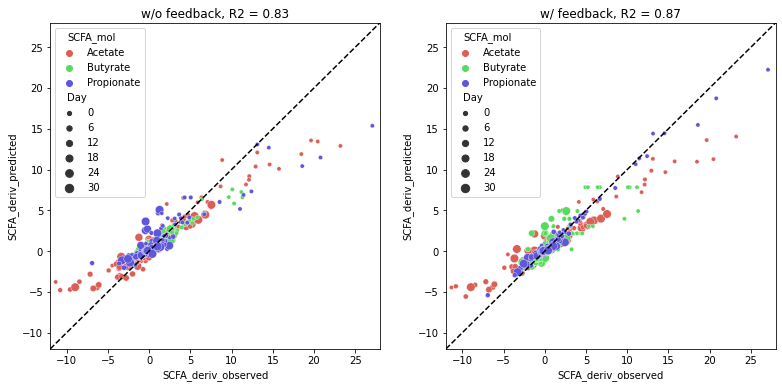

In [30]:
df_pred_no_feedback = predict_scfa_deriv(feedback=False)
df_pred_w_feedback = predict_scfa_deriv(feedback=True)

fig, ax = plt.subplots(figsize=(13,6), nrows=1, ncols=2)

# no feedback
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df_pred_no_feedback, ax=ax[0])
_ = ax[0].plot([-12,28],[-12,28],'k--')
_ = ax[0].set_xlim([-12,28])
_ = ax[0].set_ylim([-12,28])
_ = ax[0].set_title('w/o feedback, R2 = %2.2f'%(r2_score(df_pred_no_feedback.SCFA_deriv_observed, df_pred_no_feedback.SCFA_deriv_predicted)))

# w/ feedback
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df_pred_w_feedback, ax=ax[1])
_ = ax[1].plot([-12,28],[-12,28],'k--')
_ = ax[1].set_xlim([-12,28])
_ = ax[1].set_ylim([-12,28])
_ = ax[1].set_title('w/ feedback, R2 = %2.2f'%(r2_score(df_pred_w_feedback.SCFA_deriv_observed, df_pred_w_feedback.SCFA_deriv_predicted)))